In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv, concat
from tqdm import tqdm
sns.set_theme(style='ticks', context='notebook', font_scale=1.1)

## Section 1: Behavior

In [2]:
## Load data.
data = concat([read_csv(os.path.join('data', session, 'pgng.csv'))
               for session in ['s1','s2','s3','s4']])

## Restrict participants.
reject = read_csv(os.path.join('data', 's1', 'reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)].reset_index(drop=True)

## Return number of participants per session.
print(data.groupby('session').subject.nunique())

session
1    103
2     94
3     92
4     89
Name: subject, dtype: int64


### 1.1 Learning curves

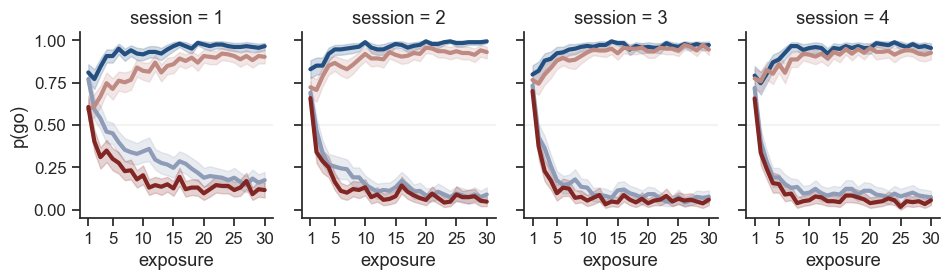

In [3]:
## Initialize canvas.
g = sns.FacetGrid(data, col='session', col_order=[1,2,3,4], aspect=0.8)

## Define aesthetics.
palette = ['#234f81', '#8e9cb8', '#bf8a82', '#812623']
hue_order = ['gw','ngw','gal','ngal']

## Plot learning curves.
g.map(sns.lineplot, 'exposure', 'choice', 'robot', hue_order=hue_order, palette=palette, 
      lw=3, errorbar=('ci', 95))

## Add trend line.
for ax in g.axes.flatten(): ax.axhline(0.5, color='k', alpha=0.05, zorder=-1)

## Adjust x-axis.
g.set(xticks=np.append(1, np.arange(5,31,5)))
g.set_xlabels('exposure')

## Adjust y-axis.
g.set_ylabels('p(go)');

### 1.2 Descriptive statistics

In [4]:
from itertools import combinations

## Define parameters.
n_iter = 5000
sessions = [1,2,3,4]
pairs = list(combinations(sessions, 2))

## Define convenience functions.
def mad(x):
    """Median absolute difference."""
    return np.nanmedian(np.abs(x - np.nanmedian(x)))

def cohens_d(x, popmean=0):
    """Cohen's D for one-sample median."""
    return np.abs(np.nanmedian(x) - popmean) / (mad(x) / 0.6745)

def resample(x):
    """Bootstrap resampling."""
    return np.random.choice(x, len(x), replace=True)

#### 1.2.1 Overall performance

**Within-session comparisons**

In [5]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance (adjusted for midpoint).
pivot = data.pivot_table('accuracy', 'subject', 'session') - 0.5

## Compute observed effects.
obs = pivot.median().values + 0.5

## Compute effect sizes.
d = pivot.apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    null[n] = df.median().values
    
## Compute confidence intervals.
lb, ub = np.percentile(null, [2.5, 97.5], 0) + 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute sign.
    pivot = pivot * np.random.choice([1,-1], pivot.shape, replace=True)
    
    ## Compute observed effects.
    null[n] = pivot.median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:05<00:00, 886.07it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.850,2.982,0.0,0.808,0.879
2,0.929,6.947,0.0,0.904,0.946
3,0.946,10.310,0.0,0.931,0.952
4,0.946,12.029,0.0,0.938,0.958


**Between-session comparisons**

In [6]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance (adjusted for midpoint).
pivot = data.pivot_table('accuracy', 'subject', 'session')

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
     ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])
        
## Compute confidence intervals.
lb, ub = np.percentile(null, [2.5, 97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:19<00:00, 255.92it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2  -0.056  0.792  0.000  0.000 -0.075 -0.042
   3  -0.065  0.909  0.000  0.000 -0.083 -0.050
   4  -0.058  0.858  0.000  0.000 -0.090 -0.042
2  3  -0.012  0.289  0.071  0.312 -0.019 -0.004
   4  -0.008  0.193  0.188  0.659 -0.025  0.004
3  4  -0.004  0.112  0.522  0.986 -0.015  0.004

#### 1.2.2 Main effect: required action

**Within-session comparisons**

In [7]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'action')

## Compute observed effects.
obs = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['go'] - pivot['no-go']).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['go'] - df['no-go']).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['go'] - pivot['no-go']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:44<00:00, 111.45it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.117,1.049,0.0,0.108,0.133
2,0.050,1.156,0.0,0.042,0.058
3,0.042,1.124,0.0,0.029,0.046
4,0.033,0.899,0.0,0.025,0.042


**Between-session comparisons**

In [8]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by action type.
pivot = data.pivot_table('accuracy', 'subject', ['action','session'])
pivot = pivot['go'] - pivot['no-go']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:19<00:00, 255.38it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2   0.025  0.337  0.000  0.000  0.008  0.058
   3   0.054  0.674  0.000  0.000  0.025  0.075
   4   0.075  0.674  0.000  0.000  0.050  0.092
2  3   0.013  0.289  0.063  0.310  0.004  0.025
   4   0.025  0.506  0.000  0.000  0.017  0.033
3  4   0.008  0.225  0.133  0.515  0.000  0.017

#### 1.2.3 Main effect: outcome valence

**Within-session comparisons**

In [9]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', ['session','subject'], 'valence')

## Compute observed effects.
obs = (pivot['win'] - pivot['lose']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['win'] - pivot['lose']).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['win'] - df['lose']).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['win'] - pivot['lose']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:44<00:00, 113.28it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.008,0.135,0.064,-0.008,0.025
2,0.008,0.169,0.017,0.000,0.025
3,0.000,0.000,0.264,-0.008,0.008
4,0.000,0.000,0.257,-0.008,0.008


**Between-session comparisons**

In [10]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by outcome valence.
pivot = data.pivot_table('accuracy', 'subject', ['valence','session'])
pivot = pivot['win'] - pivot['lose']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:21<00:00, 237.76it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2  -0.004  0.045  0.572  0.992 -0.025  0.008
   3   0.000  0.000  0.748  1.000 -0.025  0.025
   4   0.008  0.096  0.299  0.851 -0.025  0.025
2  3   0.008  0.169  0.263  0.807  0.000  0.025
   4   0.008  0.123  0.291  0.851 -0.013  0.017
3  4   0.000  0.000  0.741  1.000 -0.017  0.017

#### 1.2.4 Interaction effect: action type X outcome valence

**Within-session comparisons**

In [11]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', ['session','subject'], 'congruence')

## Compute observed effects.
obs = (pivot['c'] - pivot['i']).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot['c'] - pivot['i']).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['c'] - df['i']).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['c'] - pivot['i']).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:43<00:00, 114.43it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.092,1.237,0.000,0.067,0.117
2,0.017,0.450,0.000,0.008,0.025
3,0.017,0.450,0.000,0.008,0.025
4,0.008,0.225,0.001,0.000,0.017


**Between-session comparisons**

In [12]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by congruency.
data['congruence'] = data.robot.replace({'gw': 'c', 'ngal': 'c', 'ngw': 'i', 'gal': 'i'})
pivot = data.pivot_table('accuracy', 'subject', ['congruence','session'])
pivot = pivot['c'] - pivot['i']

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:20<00:00, 239.88it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2   0.046  0.495  0.000  0.000  0.025  0.067
   3   0.067  0.899  0.000  0.000  0.037  0.075
   4   0.075  0.867  0.000  0.000  0.050  0.100
2  3   0.008  0.169  0.262  0.808 -0.000  0.017
   4   0.017  0.270  0.060  0.270  0.008  0.029
3  4   0.004  0.096  0.666  0.998 -0.000  0.017

#### 1.2.5 Secondary effect: feedback type 

**Within-session comparisons**

In [13]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define previous exposure.
data['prev_sham'] = data.groupby(['subject','session','stimulus']).sham.transform(np.roll, 1)
data.loc[data.exposure == 1, 'prev_sham'] = np.nan

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', ['session','subject'], 'prev_sham')

## Compute observed effects.
obs = (pivot[0] - pivot[1]).groupby(level=0).median().values

## Compute effect sizes.
d = (pivot[0] - pivot[1]).groupby(level=0).apply(cohens_d).values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df[0] - df[1]).groupby(level=0).median().values

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot[0] - pivot[1]).groupby(level=0).median().values
    
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(session=sessions, obs=obs, d=d, pval=pval, lb=lb, ub=ub))
summary.set_index('session').round(3)

100%|██████████████████████████████████████| 5000/5000 [00:45<00:00, 108.82it/s]


,obs,d,pval,lb,ub
session,,,,,
1,0.094,1.250,0.0,0.072,0.115
2,0.045,0.770,0.0,0.034,0.062
3,0.030,0.581,0.0,0.018,0.047
4,0.028,0.704,0.0,0.022,0.043


**Between-session comparisons**

In [14]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by feedback type.
pivot = data.pivot_table('accuracy', 'subject', ['prev_sham','session'])
pivot = pivot[0] - pivot[1]

## Compute observed effects.
obs = np.array([np.nanmedian(pivot[a] - pivot[b]) for a, b in pairs])

## Compute effect sizes.
d = np.array([cohens_d(pivot[a] - pivot[b]) for a, b in pairs])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.loc[resample(pivot.index)].copy()
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(df[a] - df[b])

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5], 0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros((n_iter, obs.size))
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    for m, (a, b) in enumerate(pairs):
        null[n,m] = np.nanmedian(pivot[a] - pivot[b])
        
## Compute p-values.
pval = ((np.abs(obs[np.newaxis,:]) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)
fwer = ((np.abs(obs[:,np.newaxis]) < np.abs(null).max(axis=1)).sum(axis=1) + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Construct DataFrame.
summary = DataFrame(dict(s1=[a for a, b in pairs], s2=[b for a, b in pairs], 
                         obs=obs, d=d, pval=pval, fwer=fwer, lb=lb, ub=ub))
summary.set_index(['s1','s2']).round(3)

100%|██████████████████████████████████████| 5000/5000 [00:20<00:00, 243.13it/s]


obs      d   pval   fwer     lb     ub
s1 s2                                          
1  2   0.038  0.492  0.000  0.000  0.016  0.061
   3   0.039  0.572  0.000  0.000  0.026  0.065
   4   0.053  0.777  0.000  0.000  0.034  0.071
2  3   0.008  0.137  0.283  0.841 -0.005  0.029
   4   0.019  0.326  0.034  0.180  0.000  0.034
3  4   0.011  0.201  0.175  0.630  0.000  0.027

#### 1.2.6 Secondary effect: scanner color

**Overall accuracy**

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average performance by scanner color.
pivot = data.pivot_table('accuracy', ['session','subject'], 'color')

## Compute observed effects.
obs = (pivot['blue'] - pivot['yellow']).median()

## Compute effect sizes.
d = cohens_d(pivot['blue'] - pivot['yellow'])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Bootstrap confidence interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute bootstrapped distribution.
null = np.zeros(n_iter)
for n in tqdm(range(n_iter)):
    
    ## Resample participants.
    df = pivot.groupby(level=0).apply(lambda x: x.loc[resample(x.index)])
    
    ## Compute observed effects.
    null[n] = (df['blue'] - df['yellow']).median()

## Compute confidence interval.
lb, ub = np.percentile(null, [2.5,97.5])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute null distribution.
null = np.zeros(n_iter)
for n in tqdm(range(n_iter)):
    
    ## Permute group assignments.
    pivot.loc[:,:] = np.stack(pivot.apply(np.random.permutation, 1).values)
    
    ## Compute observed effects.
    null[n] = (pivot['blue'] - pivot['yellow']).median()
    
## Compute p-values.
pval = ((np.abs(obs) < np.abs(null)).sum(axis=0) + 1) / (n_iter + 1)

## Report summary.
print('obs = %0.3f (d = %0.3f, p = %0.3f, 95%% CI = [%0.3f, %0.3f])' %(obs, d, pval, lb, ub))

100%|██████████████████████████████████████| 5000/5000 [00:42<00:00, 118.35it/s]

obs = 0.000 (d = 0.000, p = 0.077, 95% CI = [-0.008, 0.008])


### 1.3 Individual-differences

In [16]:
from scipy.stats import chi2_contingency

## Compute accuracy by participant / session / condition.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()

## Score performance into top five deciles.
gb['score'] = np.digitize(gb.accuracy, [0.6,0.9])

## Calculate proportion of participants in each bin.
pivot = gb.pivot_table('subject', ['robot','score'], 'session', aggfunc='count').fillna(0)

for robot in ['gw','ngw','gal','ngal']:
    chi2, pval, dof, _ = chi2_contingency(pivot.loc[robot])
    print('%s\tx2(df=%s) = %0.3f (p = %0.3f)' %(robot, dof, chi2, pval))

gw	x2(df=6) = 8.149 (p = 0.227)
ngw	x2(df=6) = 55.458 (p = 0.000)
gal	x2(df=6) = 42.191 (p = 0.000)
ngal	x2(df=6) = 39.287 (p = 0.000)
